# Calculate relationship between AP and dendritic spikes with poisson excitation and rhythmic inhibition with variable frequency

The simulations had either: 
1. Rhythmic inhibition at the soma (64 Hz) or dendrites (16 Hz) 
2. Poisson excitation at the soma and dendrites

Here we calculate the spike-triggered average between dendritic spikes and action potentials. These are stratified by:
1. electrotonic distance of the dendritic segment from the soma
2. whether the dendritic branch was apical or basal
3. type of dendritic spike

The output of this script are a collection of NPY files, one for each simulation condition, dendrite type, and dendritic spike type, containing a numpy array with 3 dimensions:
1. the dendritic segment electrotonic quantile
2. time from the action potential

In [44]:
import sys
sys.path.append('..') # have to do this for relative imports in jupyter
import numpy as np
import pandas as pd
import h5py
from scipy.signal import hilbert
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from src.bin_rhythmic_files import bin_rhythmic_files
from src.ent_rhythmic_files import ent_rhythmic_files
from src.load_spike_h5 import load_spike_h5
from src.ser_pt import ser_pt
from src.bin_serser import bin_serser
from src.cc_phdep_files import cc_phdep_files

from src.load_dendevt_csv import load_dendevt_csv
from src.seg_dendevt import seg_dendevt
from src.ser_seg_dendevt import ser_seg_dendevt
from src.mean_dendevt import mean_dendevt
from src.ppc import ppc2

## 1.0 Analysis parameters


### 1.1 Simulation constants and analysis windows

In [45]:
samps_per_ms = 10 
sim_win = [0, 3000000] # beginning and start points of simulation in samples
sta_win = [-100, 100] # multiply by step to get window in milliseconds
sta_step = 1 # binning step for each point in the STA
step = 1 * samps_per_ms # number of simulation steps for creating the dendritic 
                        # event occurrence series
ph_bin_num = 8
edges = np.linspace(-np.pi, np.pi, ph_bin_num)

## For distal inhibition

### 1.2 List files to be processed

In [4]:
freq_list = [0.5, 2, 5, 10, 16, 20, 30, 40, 50, 60, 80]
freq_list_str = list(map(str, freq_list))
freq_list_str[0] = 'p5'
root_dir = 'Y:\\DendCompOsc\\'
# Create sim dictionaries
sim_dicts = {}
for i in range(len(freq_list)):
    sim_name = freq_list_str[i] + 'Hzdistal_inh'
    sim_dir = root_dir + sim_name + '\\' 
    # generate phase time series for inhibitory afferents
    t_ser = np.arange(sim_win[0], sim_win[1], step) / (10000) # seconds
    sin_inh = np.sin(t_ser*freq_list[i]*2*np.pi)
    ph_inh = np.angle(hilbert(sin_inh))
    sim_dicts[freq_list_str[i]] = {'SimName': sim_name, 
                                   'RootDir': sim_dir,
                                   'CaFile': sim_dir + sim_name + '_ca.csv',
                                   'NaFile': sim_dir + sim_name + '_na.csv',
                                   'NMDAFile': sim_dir + sim_name + '_nmda.csv', 
                                   'APFile': sim_dir + 'spikes.h5',
                                   'VmFile': sim_dir + 'v_report.h5',
                                   'InhSin': sin_inh,
                                   'InhPhase': ph_inh,
                                   'Freq': freq_list[i], 
                                   'Location': 'distal'}


In [ ]:
# phase bin dendritic and action potential files function
def bin_files_func(sim_dict):
    ph_bin = {}

    # process dendritic events
    ph_bin['ca_bin'] = bin_rhythmic_files(sim_dict['CaFile'], sim_dict['InhPhase'], step, sim_win,ph_bin_num)
    ph_bin['nmda_bin'] = bin_rhythmic_files(sim_dict['NMDAFile'], sim_dict['InhPhase'], step, sim_win,ph_bin_num)
    ph_bin['na_bin'] = bin_rhythmic_files(sim_dict['NaFile'], sim_dict['InhPhase'], step, sim_win,ph_bin_num)

    ph_bin['ca_a'] = ph_bin['ca_bin'].loc['apic','ph_bin']
    ph_bin['nmda_a'] = ph_bin['nmda_bin'].loc['apic','ph_bin']
    ph_bin['nmda_b'] = ph_bin['nmda_bin'].loc['dend','ph_bin']
    ph_bin['na_a'] = ph_bin['na_bin'].loc['apic','ph_bin']
    ph_bin['na_b'] = ph_bin['na_bin'].loc['dend','ph_bin']
    

    # process action potential events
    spk_t = load_spike_h5(sim_dict['APFile'])
    spk_ser = ser_pt(spk_t, step, sim_win)
    spk_ser = np.array(spk_ser)*1000

    ph_bin['ap'] = bin_serser(spk_ser.astype(float), sim_dict['InhPhase'], edges, func=np.nanmean)["values"]
    ph_bin['sin'] = bin_serser(sim_dict['InhSin'], sim_dict['InhPhase'], edges, func=np.nanmean)["values"]
    return ph_bin

In [6]:
bin_data = {}
for k, v in sim_dicts.items():
    print('Processing ' + k)
    bin_data[k] = bin_files_func(v)


Processing p5


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))
c:\Users\dbh60\.conda\envs\dend_comp\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))
c:\Users\d

Processing 2


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))
c:\Users\dbh60\.conda\envs\dend_comp\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))
c:\Users\d

Processing 5


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))
c:\Users\dbh60\.conda\envs\dend_comp\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))
c:\Users\d

Processing 10


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))
c:\Users\dbh60\.conda\envs\dend_comp\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))
c:\Users\d

Processing 16


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))
c:\Users\dbh60\.conda\envs\dend_comp\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))
c:\Users\d

Processing 20


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))
c:\Users\dbh60\.conda\envs\dend_comp\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))
c:\Users\d

Processing 30


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))
c:\Users\dbh60\.conda\envs\dend_comp\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))
c:\Users\d

Processing 40


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))
c:\Users\dbh60\.conda\envs\dend_comp\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))
c:\Users\d

Processing 50


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))
c:\Users\dbh60\.conda\envs\dend_comp\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))
c:\Users\d

Processing 60


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))
c:\Users\dbh60\.conda\envs\dend_comp\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))
c:\Users\d

Processing 80


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))
c:\Users\dbh60\.conda\envs\dend_comp\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))
c:\Users\d

In [7]:
# plotting functions
def stairs_plot(sig_ser, sin_ser, ax):
        sc_func = lambda x: ((x+1)/2)*np.max(sig_ser[1:])

        ax.stairs(np.hstack((sig_ser[1:],sig_ser[1:])),
                np.hstack((edges[:-1], edges+2*np.pi)), 
                baseline=0, fill=True)
        ax.plot(np.hstack((edges, edges+2*np.pi)), 
                np.hstack((sc_func(sin_ser), sc_func(sin_ser))),color='k')
        ax.plot(np.linspace(-np.pi,3*np.pi,100),
                sc_func(np.sin(np.linspace(-np.pi,3*np.pi,100)+(np.pi/2))), 
                color='r', linestyle=':')
        ax.set_xticks(np.pi/2*np.arange(-2,7))
        ax.tick_params(axis='x', rotation=90)


eqt_list = np.arange(9,0,-1)
eqt_inds = np.where(eqt_list>0)[0]
def plot_sta_im(data_arr,vlim, ax):
    ax_im = ax.imshow(np.hstack((data_arr[eqt_inds[0]:eqt_inds[-1],1:], 
                                 data_arr[eqt_inds[0]:eqt_inds[-1],1:])),
                      extent=[-np.pi, 3*np.pi, eqt_list[eqt_inds[0]], eqt_list[eqt_inds[-1]]],
                      vmin=vlim[0], vmax=vlim[1],
                      interpolation='none',
                      cmap='coolwarm')
    
    plt.colorbar(ax_im,ax=ax)
    ax.set_aspect('auto')

# array plots
def plot_dend_set(ph_bin_data, vlim, fig, ax):
    plot_sta_im(ph_bin_data['nmda_a'], vlim, ax[0,0])
    ax[0,0].set_title('NMDA Apical')
    ax[0,0].set_xticks(np.pi/2*np.arange(-2,7))
    ax[0,0].tick_params(axis='x', rotation=90)
    plot_sta_im(ph_bin_data['nmda_b'], vlim, ax[1,0])
    ax[1,0].set_title('NMDA Basal')
    ax[1,0].set_xticks(np.pi/2*np.arange(-2,7))
    ax[1,0].tick_params(axis='x', rotation=90)
    plot_sta_im(ph_bin_data['na_a'], vlim, ax[0,1])
    ax[0,1].set_title('Na Apical')
    ax[0,1].set_xticks(np.pi/2*np.arange(-2,7))
    ax[0,1].tick_params(axis='x', rotation=90)
    plot_sta_im(ph_bin_data['na_b'], vlim, ax[1,1])
    ax[1,1].set_title('Na Basal')
    ax[1,1].set_xticks(np.pi/2*np.arange(-2,7))
    ax[1,1].tick_params(axis='x', rotation=90)
    fig.supxlabel('Phase of rhythm (radians)')
    fig.supylabel('Electrotonic quantile 90->0')

### Plot entrainment of action potentials

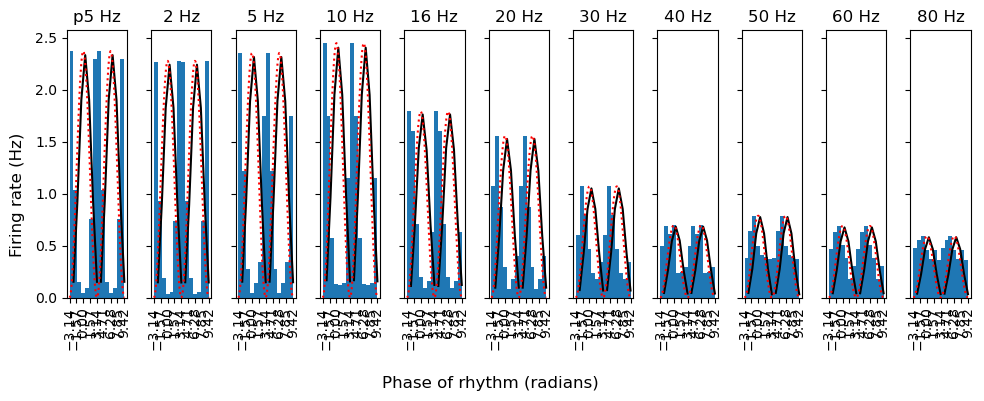

In [8]:
# Action potentials
fig, ax = plt.subplots(1,len(freq_list), figsize=[10,4], sharey=True)
for i, (k,v) in enumerate(bin_data.items()):
    stairs_plot(v['ap'], v['sin'], ax[i])
    ax[i].set_title(k + ' Hz')
fig.supxlabel('Phase of rhythm (radians)')
fig.supylabel('Firing rate (Hz)')
plt.tight_layout()


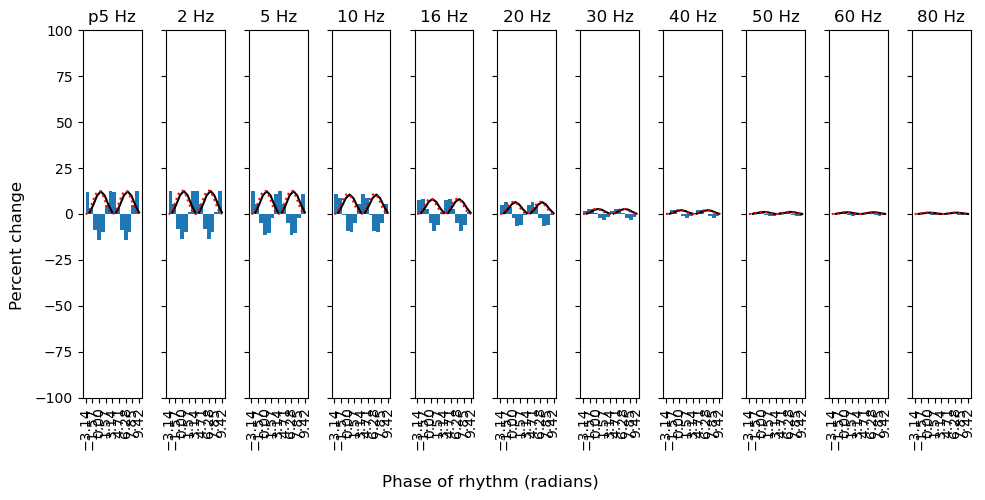

In [9]:
# plot calcium spike results
fig, ax = plt.subplots(1,len(freq_list), figsize=[10,5], sharey=True)
for i, (k,v) in enumerate(bin_data.items()):
    stairs_plot(v['ca_a'][0], v['sin'], ax[i])
    ax[i].set_ylim([-100,100])
    ax[i].set_title(k + ' Hz')
fig.supxlabel('Phase of rhythm (radians)')
fig.supylabel('Percent change')
plt.tight_layout()


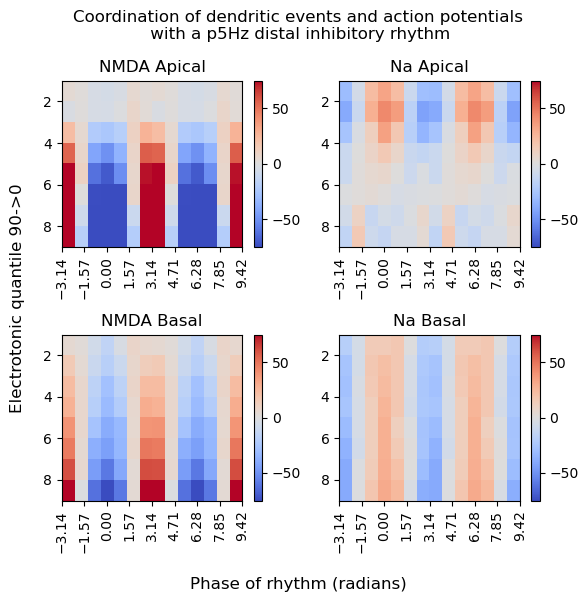

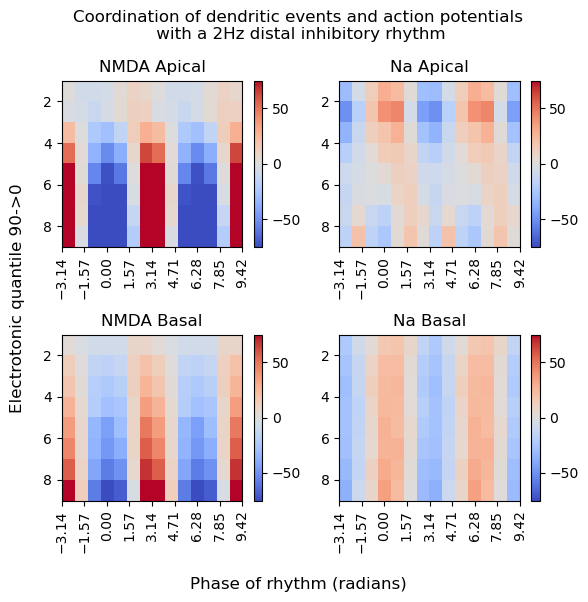

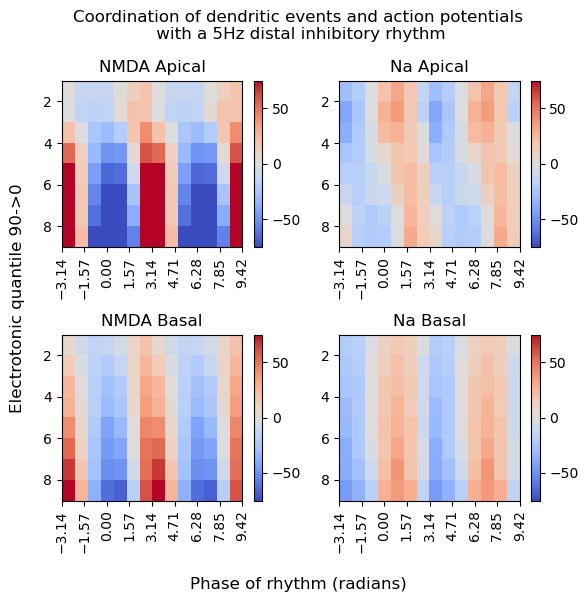

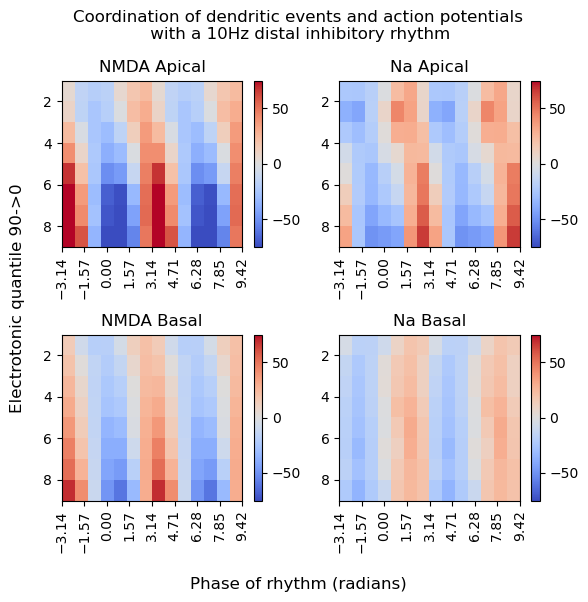

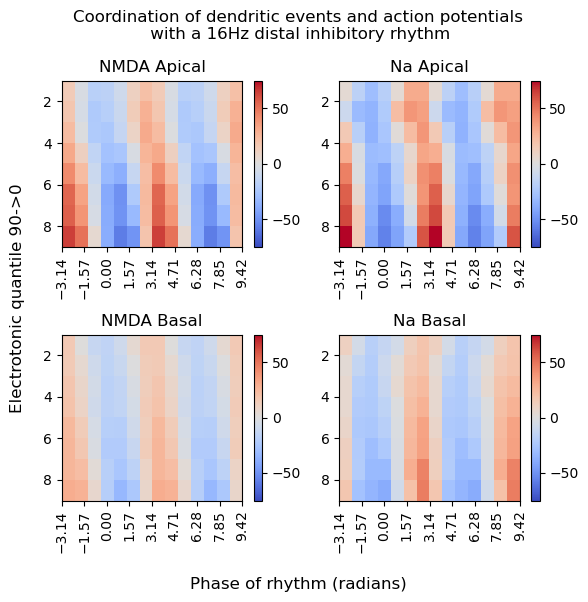

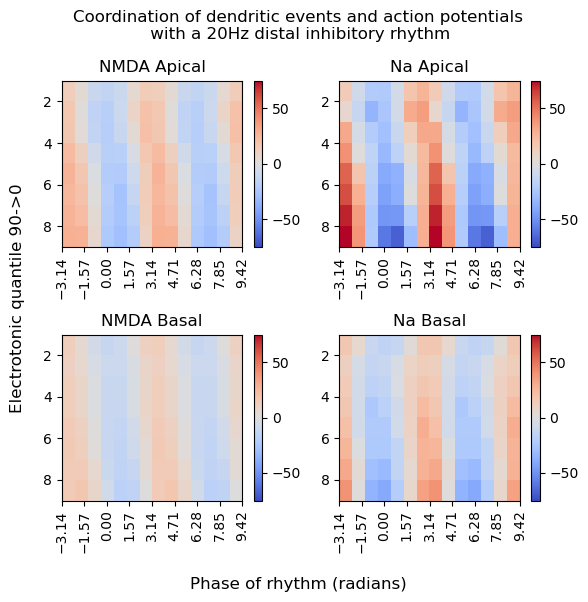

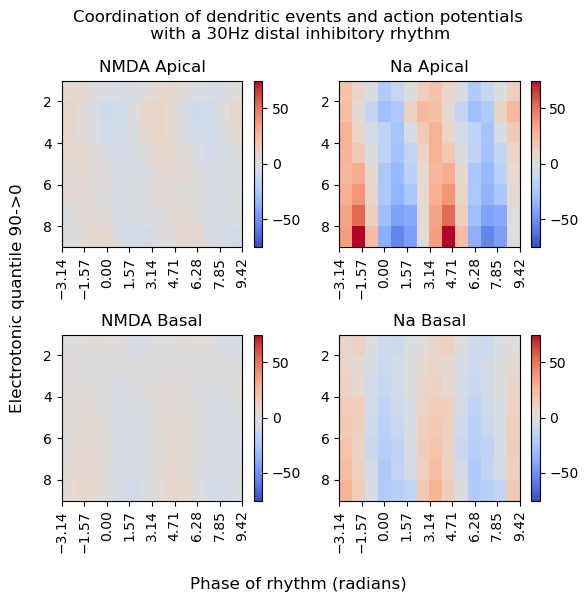

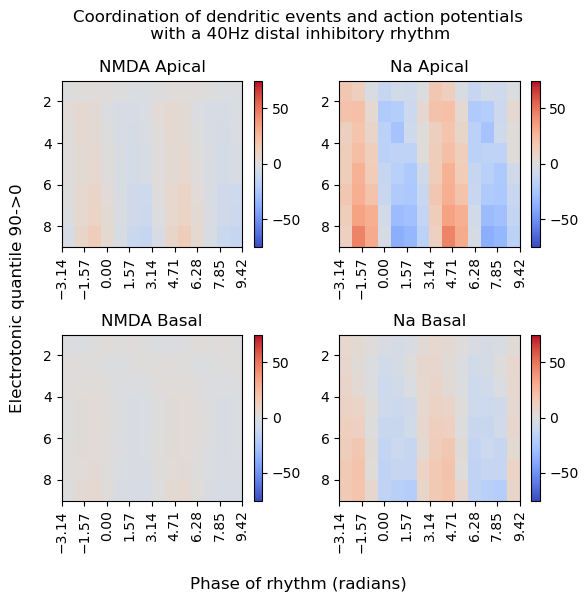

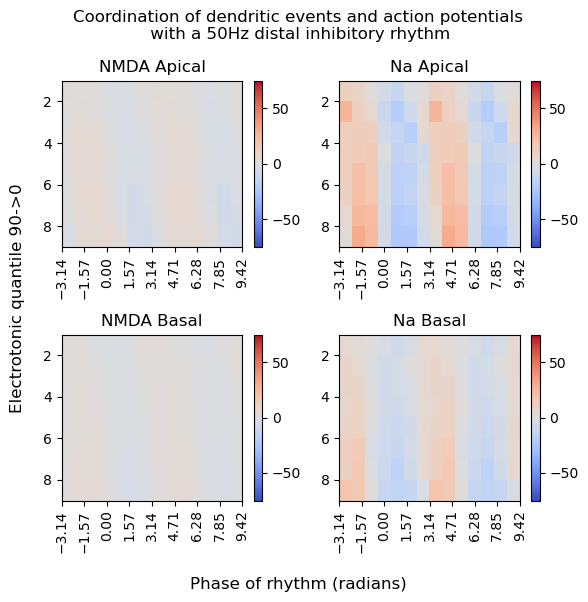

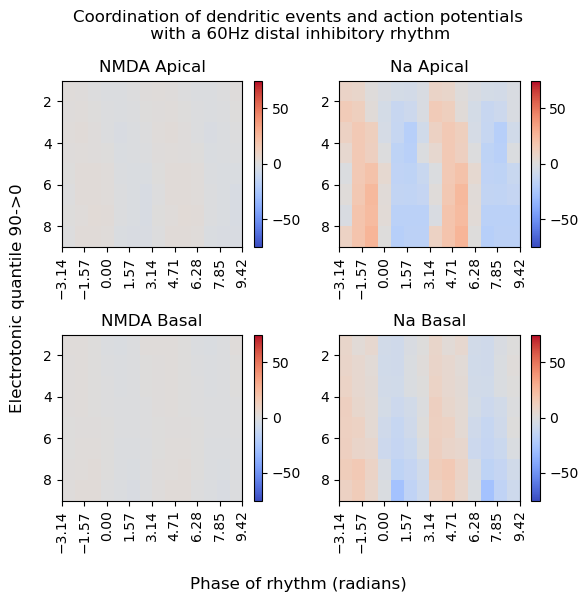

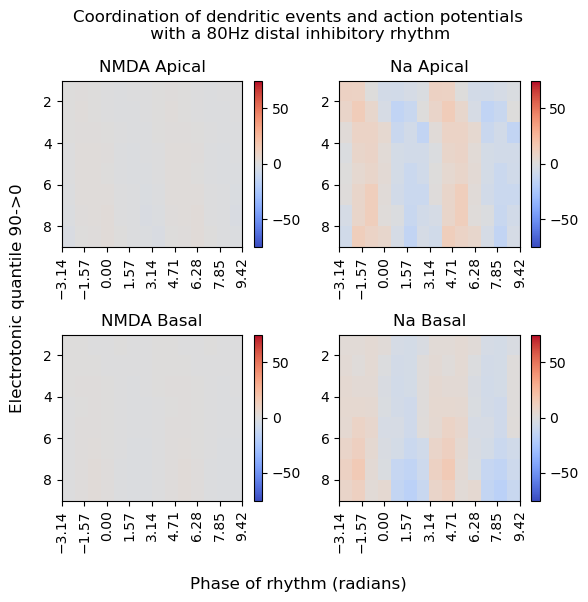

In [10]:
for i, (k,v) in enumerate(bin_data.items()):
    fig,ax = plt.subplots(2,2)
    plot_dend_set(v, [-75, 75], fig, ax)
    fig.suptitle('Coordination of dendritic events and action potentials\n'
             + ' with a {}Hz distal inhibitory rhythm'.format(k))
    fig.set_size_inches(6,6)
    fig.tight_layout()

In [11]:
# phase bin dendritic and action potential files function
ph_bin_num = 8
def ent_files_func(sim_dict):
    ph_bin = {}

    # process dendritic events
    ph_bin['ca_hist'], ph_bin['ca_ppc'] = ent_rhythmic_files(sim_dict['CaFile'], sim_dict['InhPhase'], step, ph_bin_num)
    ph_bin['nmda_hist'], ph_bin['nmda_ppc'] = ent_rhythmic_files(sim_dict['NMDAFile'], sim_dict['InhPhase'], step, ph_bin_num)
    ph_bin['na_hist'], ph_bin['na_ppc'] = ent_rhythmic_files(sim_dict['NaFile'], sim_dict['InhPhase'], step, ph_bin_num)

    ph_bin['ca_a_hist_on'] = ph_bin['ca_hist'].loc['apic','ca_lower_bound_ph_hist']
    ph_bin['ca_a_hist_off'] = ph_bin['ca_hist'].loc['apic','ca_upper_bound_ph_hist']
    ph_bin['ca_a_ppc_on'] = ph_bin['ca_ppc'].loc['apic','ca_lower_bound_ph_ppc']
    ph_bin['ca_a_ppc_off'] = ph_bin['ca_ppc'].loc['apic','ca_upper_bound_ph_ppc']
    ph_bin['nmda_a_hist_on'] = ph_bin['nmda_hist'].loc['apic','nmda_lower_bound_ph_hist']
    ph_bin['nmda_a_hist_off'] = ph_bin['nmda_hist'].loc['apic','nmda_upper_bound_ph_hist']
    ph_bin['nmda_a_ppc_on'] = ph_bin['nmda_ppc'].loc['apic','nmda_lower_bound_ph_ppc']
    ph_bin['nmda_a_ppc_off'] = ph_bin['nmda_ppc'].loc['apic','nmda_upper_bound_ph_ppc']
    ph_bin['nmda_b_hist_on'] = ph_bin['nmda_hist'].loc['dend','nmda_lower_bound_ph_hist']
    ph_bin['nmda_b_hist_off'] = ph_bin['nmda_hist'].loc['dend','nmda_upper_bound_ph_hist']
    ph_bin['nmda_b_ppc_on'] = ph_bin['nmda_ppc'].loc['dend','nmda_lower_bound_ph_ppc']
    ph_bin['nmda_b_ppc_off'] = ph_bin['nmda_ppc'].loc['dend','nmda_upper_bound_ph_ppc']
    ph_bin['na_a_hist_on'] = ph_bin['na_hist'].loc['apic','na_lower_bound_ph_hist']
    ph_bin['na_a_ppc_on'] = ph_bin['na_ppc'].loc['apic','na_lower_bound_ph_ppc']
    ph_bin['na_b_hist_on'] = ph_bin['na_hist'].loc['dend','na_lower_bound_ph_hist']
    ph_bin['na_b_ppc_on'] = ph_bin['na_ppc'].loc['dend','na_lower_bound_ph_ppc']

    # process action potential events
    spk_t = load_spike_h5(sim_dict['APFile'])
    spk_idx = np.round(spk_t / step).astype(int)
    
    # multiplying by 500 converts to firing rates, 2ms bin means 1 spike per bin
    # is a firing rate of 500 Hz.
    ph_bin['ap_hist'] = np.histogram(sim_dict['InhPhase'][spk_idx], np.linspace(-np.pi, np.pi, ph_bin_num))[0]
    ph_bin['ap_ppc'] = ppc2(sim_dict['InhPhase'][spk_idx])
    ph_bin['sin'] = bin_serser(sim_dict['InhSin'], sim_dict['InhPhase'], edges, func=np.nanmean)["values"]
    return ph_bin

In [12]:
ent_data_dist = {}
for k, v in sim_dicts.items():
    print('Processing ' + k)
    ent_data_dist[k] = ent_files_func(v)

Processing p5


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)


Processing 2


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)


Processing 5


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)


Processing 10


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)


Processing 16


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)


Processing 20


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)


Processing 30


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)


Processing 40


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)


Processing 50


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)


Processing 60


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)


Processing 80


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))


Text(0.5, 0, 'Frequency (Hz)')

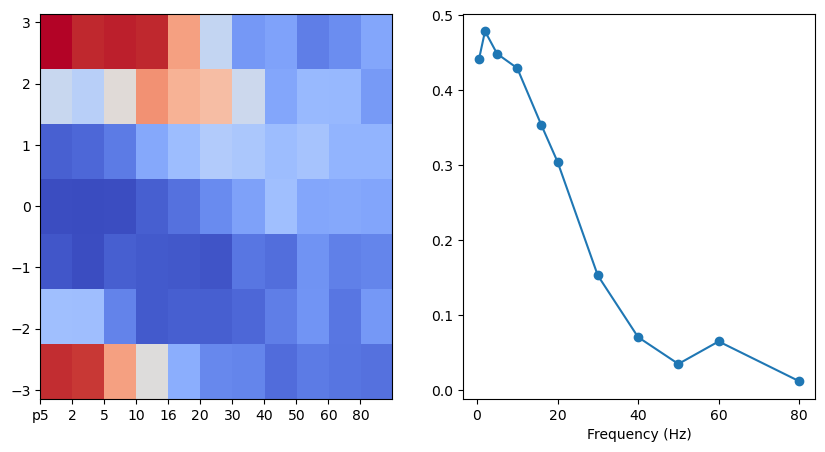

In [13]:
# AP entrainment
ap_ent = np.array([ent_data_dist[k]['ap_ppc'] for k in freq_list_str])
ap_hist = np.array([ent_data_dist[k]['ap_hist'] for k in freq_list_str]).T
fig, ax = plt.subplots(1,2, figsize=[10,5])
ax[0].imshow(ap_hist, aspect='auto', cmap='coolwarm', 
           extent=[0, len(freq_list_str), -np.pi, np.pi])
ax[0].set_xticks(np.arange(len(freq_list_str)))
ax[0].set_xticklabels(freq_list_str)
ax[1].plot(freq_list, ap_ent, marker='o')
ax[1].set_xlabel('Frequency (Hz)')

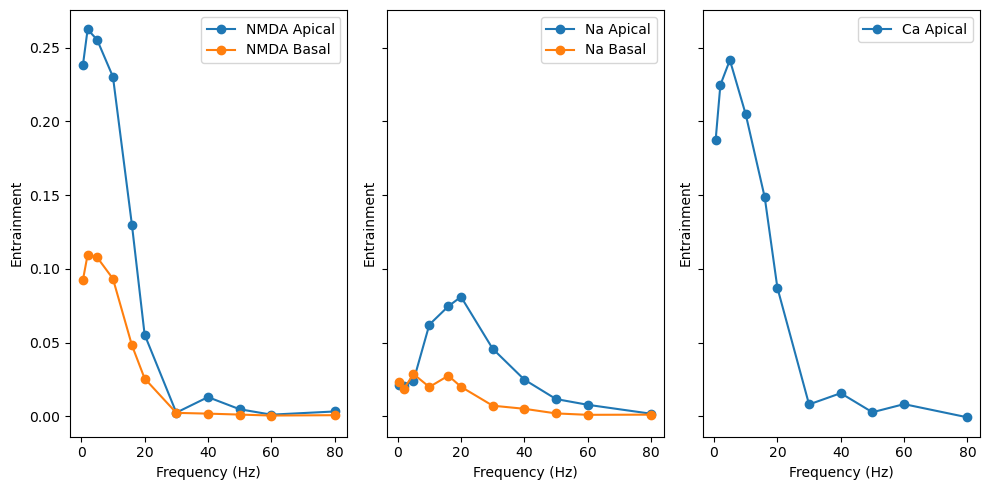

In [14]:
# entrainment for each type of dendritic event
nmda_a_ent = np.array([ent_data_dist[k]['nmda_a_ppc_on'][:-1] for k in freq_list_str]).mean(axis=1)
nmda_b_ent = np.array([ent_data_dist[k]['nmda_b_ppc_on'][:-1] for k in freq_list_str]).mean(axis=1)
na_a_ent = np.array([ent_data_dist[k]['na_a_ppc_on'][:-1] for k in freq_list_str]).mean(axis=1)
na_b_ent = np.array([ent_data_dist[k]['na_b_ppc_on'][:-1] for k in freq_list_str]).mean(axis=1)
ca_a_ent = np.array([ent_data_dist[k]['ca_a_ppc_on'][:-1] for k in freq_list_str]).mean(axis=1)

fig, ax = plt.subplots(1,3, figsize=[10,5], sharey=True)
ax[0].plot(freq_list, nmda_a_ent, marker='o', label='NMDA Apical')
ax[0].plot(freq_list, nmda_b_ent, marker='o', label='NMDA Basal')
ax[0].set_xlabel('Frequency (Hz)')
ax[0].set_ylabel('Entrainment')
ax[0].legend()
ax[1].plot(freq_list, na_a_ent, marker='o', label='Na Apical')
ax[1].plot(freq_list, na_b_ent, marker='o', label='Na Basal')
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Entrainment')
ax[1].legend()
ax[2].plot(freq_list, ca_a_ent, marker='o', label='Ca Apical')
ax[2].set_xlabel('Frequency (Hz)')
ax[2].set_ylabel('Entrainment')
ax[2].legend()
fig.tight_layout()

fig.savefig('C:\\Users\\dbh60\\Documents\\Analysis\\InhibOnDendComp\\figures\\DendriticEventEntrainment_Distal.pdf')

In [15]:
def ent_map(data, evt_type):
    """Create a map of entrainment for dendritic events."""
    ent_map = np.array([ent_data_dist[k][evt_type][:-1] for k in freq_list_str])
    ent_map = ent_map.mean(axis=1).T
    ent_map = ent_map #/ np.max(ent_map, axis=0, keepdims=True)
    return ent_map
# histogram of modulation of the onset and offset of dendritic events
nmda_a_on = ent_map(ent_data_dist, 'nmda_a_hist_on')
nmda_a_off = ent_map(ent_data_dist, 'nmda_a_hist_off')
nmda_b_on = ent_map(ent_data_dist, 'nmda_b_hist_on')
nmda_b_off = ent_map(ent_data_dist, 'nmda_b_hist_off')
ca_a_on = ent_map(ent_data_dist, 'ca_a_hist_on')
ca_a_off = ent_map(ent_data_dist, 'ca_a_hist_off')
na_a_on = ent_map(ent_data_dist, 'na_a_hist_on')
na_b_on = ent_map(ent_data_dist, 'na_b_hist_on')

In [16]:
from matplotlib.colors import LinearSegmentedColormap

def create_alpha_blended_composite(*data, colors=None, labels=None, background=None, 
                                   colorbars=True, ax=None, **kwargs):
    """
    Create an alpha-blended RGB composite image from up to 3 data arrays, each mapped to a specified color.
    
    Args:
        data: 2D numpy arrays
        A series of N 2D numpy arrays to plot. Each array will be assigned a color from the `colors` array.
        colors: Nx3 array-like, each row is an RGB color (0-1 or 0-255) for each data array.
        labels: list of strings
        A list of labels for each data array (used for the color legend).
        background: Optional 2D or 3D array to use as background (default is white).

    Optional
    --------
        colorbars: bool
            Whether to add colorbars for each data array (default is True).
        ax: Matplotlib axis object 
            Axes to draw the composite image on (if not provided, a new figure is created).
    Returns:
        composite: RGB image as numpy array, dtype float32, shape (H, W, 3)
    """

    data = np.stack(data, axis=2)

    n = data.shape[2]
    if colors is None:
        def_map = plt.get_cmap('tab10')
        colors = def_map(np.mod(np.arange(n), 10))[:,:3]  # Get first n colors from the colormap
    else:
        colors = np.array(colors)
        if colors.shape[0] < n:
            raise ValueError("Not enough colors specified for the number of data arrays.")
    
    if labels is None:
        labels = [f"Data {i}" for i in range(n)]

    if ax is None:
        fig, ax = plt.subplots()

    data_mins = np.nanmin(data, axis=(0,1), keepdims=True)
    data_maxs = np.nanmax(data, axis=(0,1), keepdims=True)

    # Normalize data to [0,1] for each channel
    data = np.clip((data - data_mins) / (data_maxs - data_mins + 1e-8), 0, 1)

    # Prepare background
    shape = data.shape[:2]
    if background is None:
        back_color = np.ones((1,1,3))
    else:
        try:
            back_color = np.array(background).reshape(1, 1, 3).astype(np.float32)
        except:
            raise ValueError("Background color must be 3 length vector")

    # Alpha blending
    alpha = np.max(data,axis=2,keepdims=True)

    # Create image using additive color mixing
    add_img = np.zeros((shape[0], shape[1], 3), dtype=np.float32)
    for i in range(n):
        add_img += data[:,:,i][:,:,np.newaxis] * colors[i].reshape(1, 1, 3)

    composite = (1 - alpha) * back_color + alpha * add_img
    ax.imshow(composite, **kwargs)

    # add a colorbar for each data array
    if colorbars:
        for i in range(n):
            cmap = LinearSegmentedColormap.from_list("custom_cmap", [back_color.reshape(-1), colors[i]])
            sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=data_mins[0,0,i], vmax=data_maxs[0,0,i]))
            sm.set_array([])
            ax.figure.colorbar(sm, ax=ax, orientation='vertical', label=labels[i])

    return ax

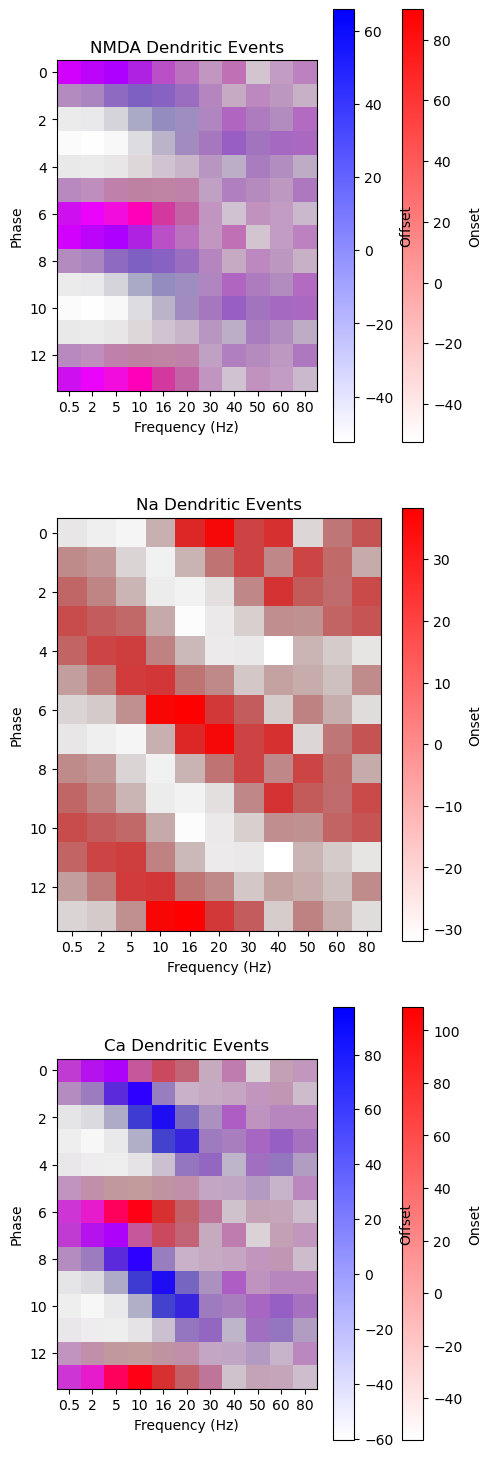

In [17]:
fig, axs = plt.subplots(3,1, figsize=[5,15])
create_alpha_blended_composite(np.tile((nmda_a_on+nmda_b_on)/2,(2,1)), 
                               np.tile((nmda_a_off+nmda_b_off)/2,(2,1)),
                               background=[1, 1, 1], 
                               colors=[[1, 0, 0], [0, 0, 1]],
                               labels=['Onset', 'Offset'],
                               ax=axs[0])
axs[0].set_xticks(np.arange(nmda_a_on.shape[1]))
axs[0].set_xticklabels(freq_list)
axs[0].set_xlabel('Frequency (Hz)')
axs[0].set_ylabel('Phase')
axs[0].set_title('NMDA Dendritic Events')
create_alpha_blended_composite(np.tile((na_b_on+na_a_on)/2,(2,1)),
                               background=[1, 1, 1], 
                               colors=[[1, 0, 0]],
                               labels=['Onset'],
                               ax=axs[1])
axs[1].set_xticks(np.arange(na_a_on.shape[1]))
axs[1].set_xticklabels(freq_list)
axs[1].set_xlabel('Frequency (Hz)')
axs[1].set_ylabel('Phase')
axs[1].set_title('Na Dendritic Events')
create_alpha_blended_composite(np.tile(ca_a_on,(2,1)), 
                               np.tile(ca_a_off,(2,1)),
                               background=[1, 1, 1], 
                               colors=[[1, 0, 0], [0, 0, 1]],
                               labels=['Onset', 'Offset'],
                               ax=axs[2])
axs[2].set_xticks(np.arange(ca_a_on.shape[1]))
axs[2].set_xticklabels(freq_list)
axs[2].set_xlabel('Frequency (Hz)')
axs[2].set_ylabel('Phase')
axs[2].set_title('Ca Dendritic Events')
fig.tight_layout()
fig.savefig('C:\\Users\\dbh60\\Documents\\Analysis\\InhibOnDendComp\\figures\\DendriticEventHistograms_Distal.pdf')


## For proximal inhibition

In [46]:
freq_list =  [0.5, 2, 5, 10, 16, 20, 30, 40, 50, 60, 80]
freq_list_str = list(map(str, freq_list))
freq_list_str[0] = 'p5'
root_dir = 'Y:\\DendCompOsc\\'
# Create sim dictionaries
sim_dicts = {}
for i in range(len(freq_list)):
    sim_name = freq_list_str[i] + 'Hzproximal_inh'
    sim_dir = root_dir + sim_name + '\\' 
    # generate phase time series for inhibitory afferents
    t_ser = np.arange(sim_win[0], sim_win[1], step) / (10000) # seconds
    sin_inh = np.sin(t_ser*freq_list[i]*2*np.pi)
    ph_inh = np.angle(hilbert(sin_inh))
    sim_dicts[freq_list_str[i]] = {'SimName': sim_name, 
                                   'RootDir': sim_dir,
                                   'CaFile': sim_dir + sim_name + '_ca.csv',
                                   'NaFile': sim_dir + sim_name + '_na.csv',
                                   'NMDAFile': sim_dir + sim_name + '_nmda.csv', 
                                   'APFile': sim_dir + 'spikes.h5',
                                   'VmFile': sim_dir + 'v_report.h5',
                                   'InhSin': sin_inh,
                                   'InhPhase': ph_inh,
                                   'Freq': freq_list[i], 
                                   'Location': 'proximal'}

In [47]:
bin_data = {}
for k, v in sim_dicts.items():
    print('Processing ' + k)
    bin_data[k] = bin_files_func(v)

Processing p5


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))
c:\Users\dbh60\.conda\envs\dend_comp\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))
c:\Users\d

Processing 2


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))
c:\Users\dbh60\.conda\envs\dend_comp\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))
c:\Users\d

Processing 5


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))
c:\Users\dbh60\.conda\envs\dend_comp\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))
c:\Users\d

Processing 10


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))
c:\Users\dbh60\.conda\envs\dend_comp\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))
c:\Users\d

Processing 16


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))
c:\Users\dbh60\.conda\envs\dend_comp\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))
c:\Users\d

Processing 20


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))
c:\Users\dbh60\.conda\envs\dend_comp\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))
c:\Users\d

Processing 30


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))
c:\Users\dbh60\.conda\envs\dend_comp\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))
c:\Users\d

Processing 40


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))
c:\Users\dbh60\.conda\envs\dend_comp\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))
c:\Users\d

Processing 50


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))
c:\Users\dbh60\.conda\envs\dend_comp\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))
c:\Users\d

Processing 60


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))
c:\Users\dbh60\.conda\envs\dend_comp\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))
c:\Users\d

Processing 80


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))
c:\Users\dbh60\.conda\envs\dend_comp\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))
c:\Users\d

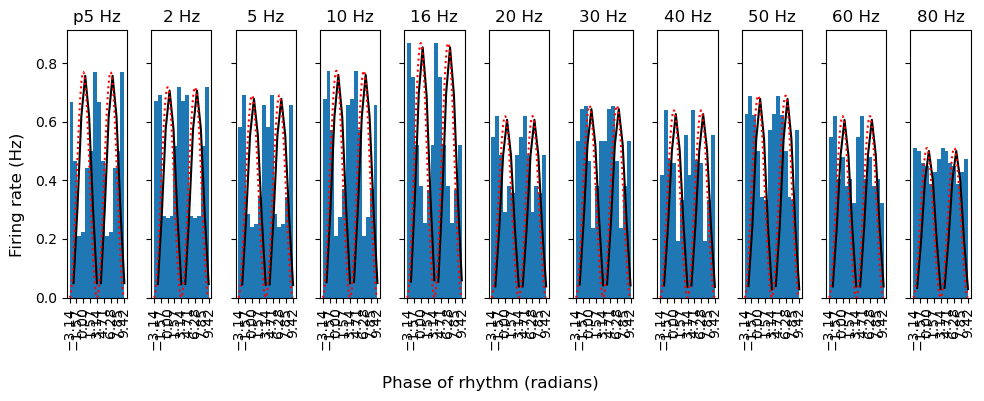

In [48]:
# Action potentials
fig, ax = plt.subplots(1,len(freq_list), figsize=[10,4], sharey=True)
for i, (k,v) in enumerate(bin_data.items()):
    stairs_plot(v['ap'], v['sin'], ax[i])
    ax[i].set_title(k + ' Hz')
fig.supxlabel('Phase of rhythm (radians)')
fig.supylabel('Firing rate (Hz)')
plt.tight_layout()


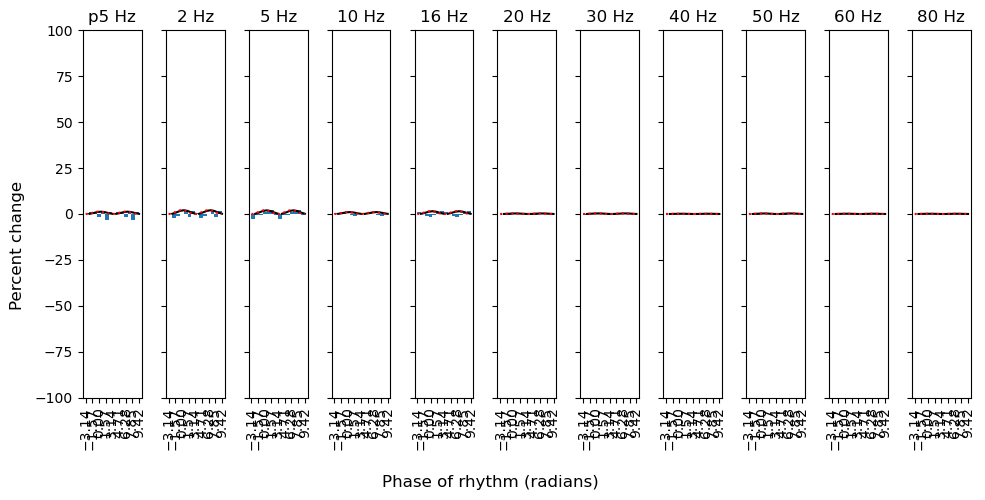

In [49]:
# plot calcium spike results
fig, ax = plt.subplots(1,len(freq_list), figsize=[10,5], sharey=True)
for i, (k,v) in enumerate(bin_data.items()):
    stairs_plot(v['ca_a'][0], v['sin'], ax[i])
    ax[i].set_ylim([-100,100])
    ax[i].set_title(k + ' Hz')
fig.supxlabel('Phase of rhythm (radians)')
fig.supylabel('Percent change')
plt.tight_layout()

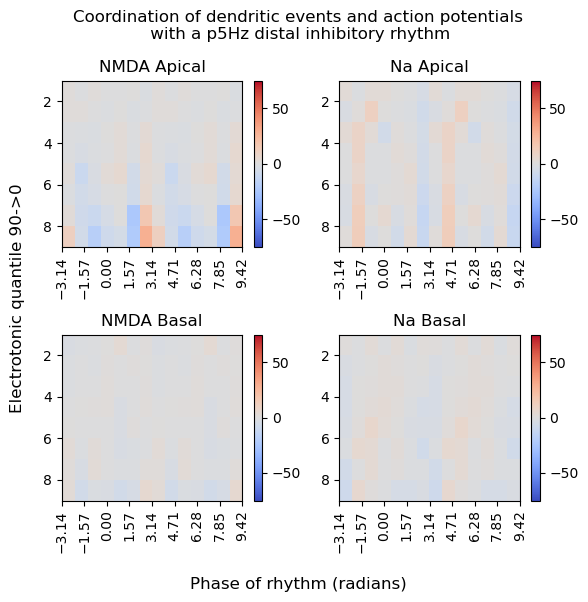

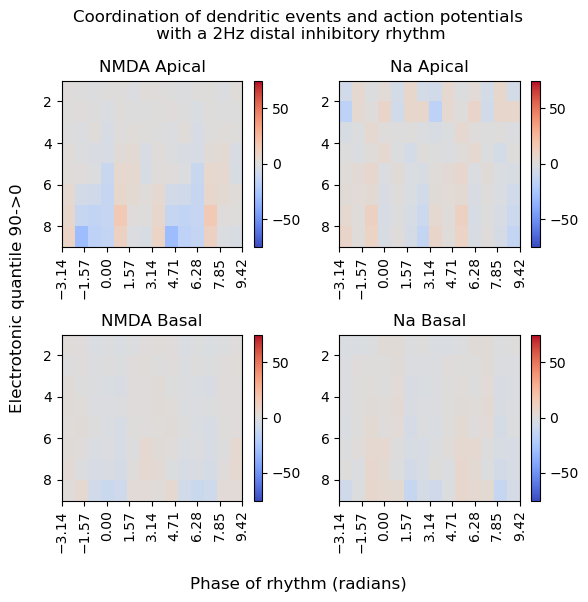

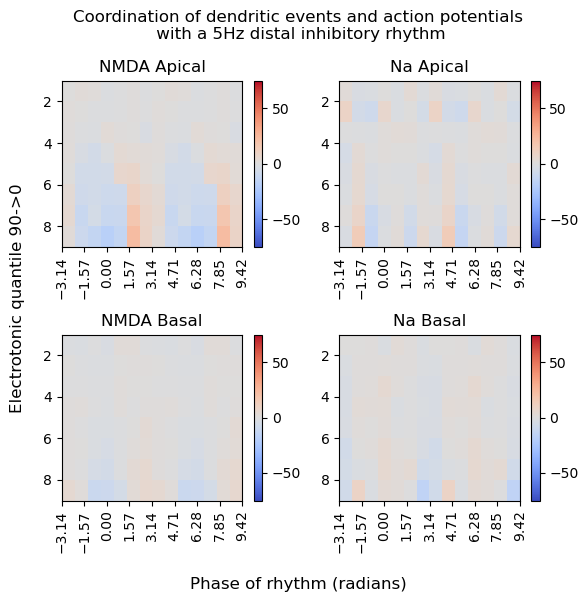

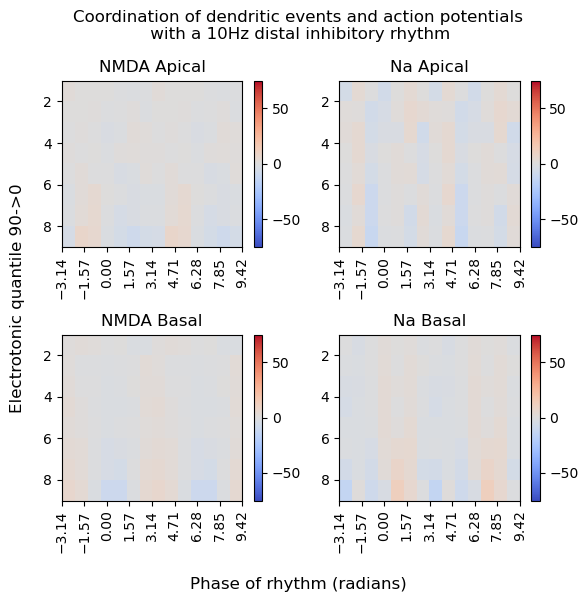

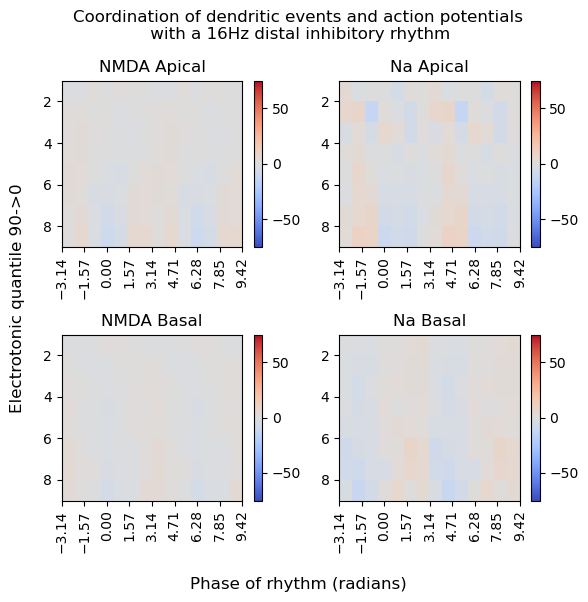

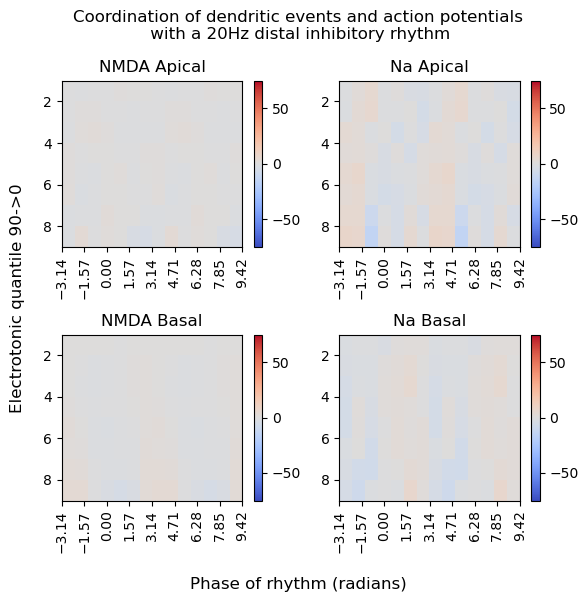

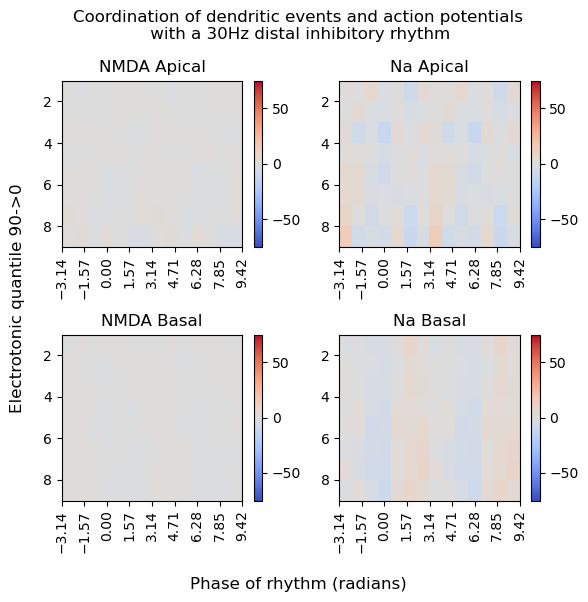

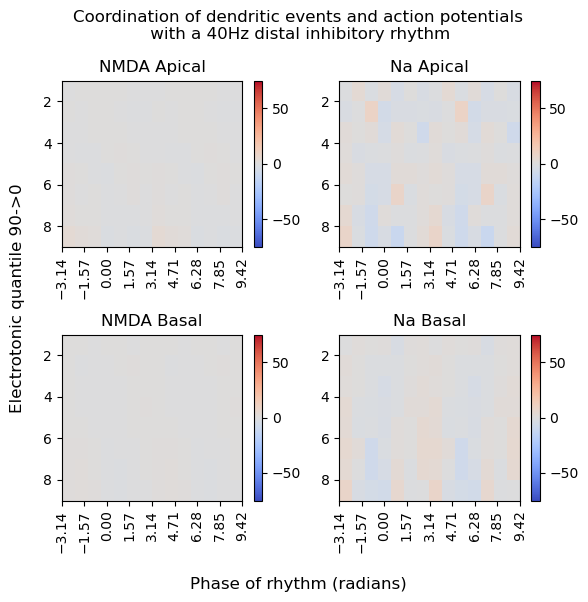

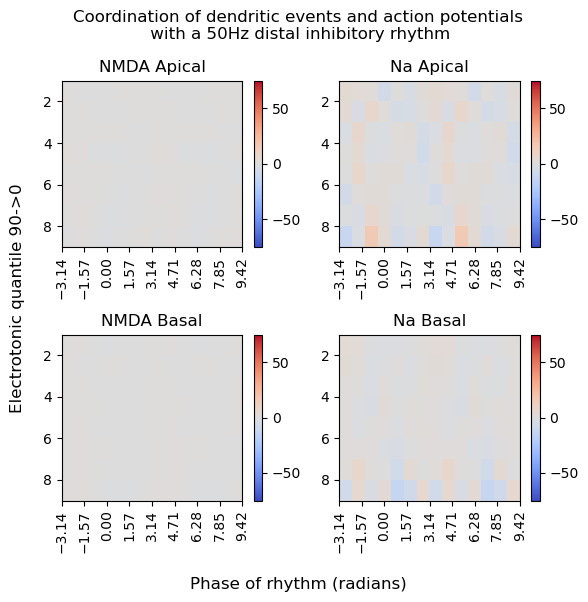

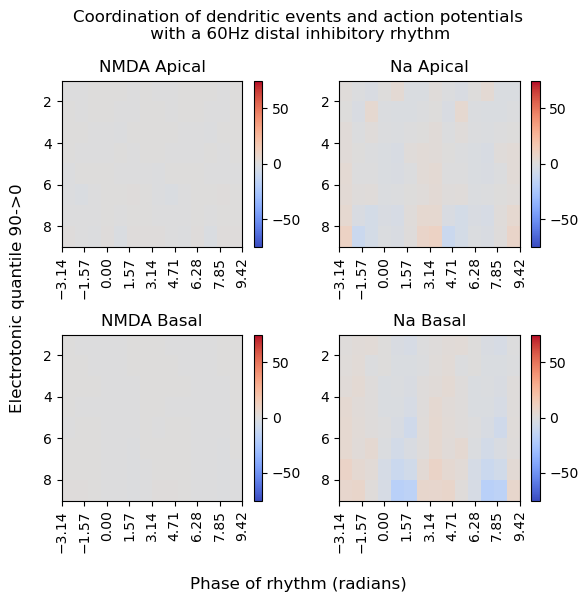

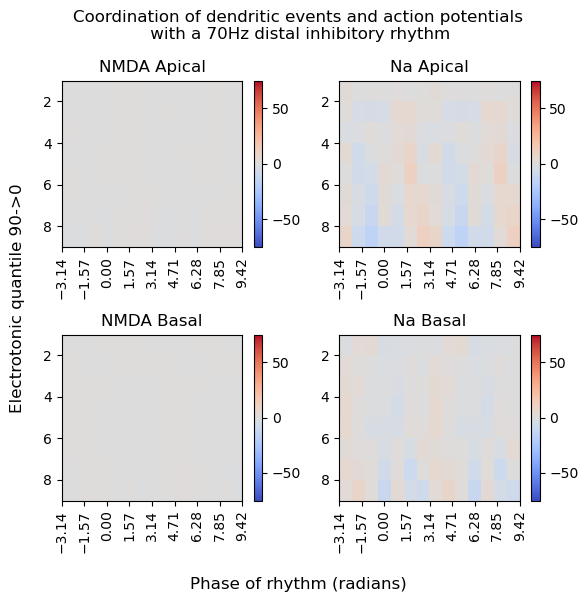

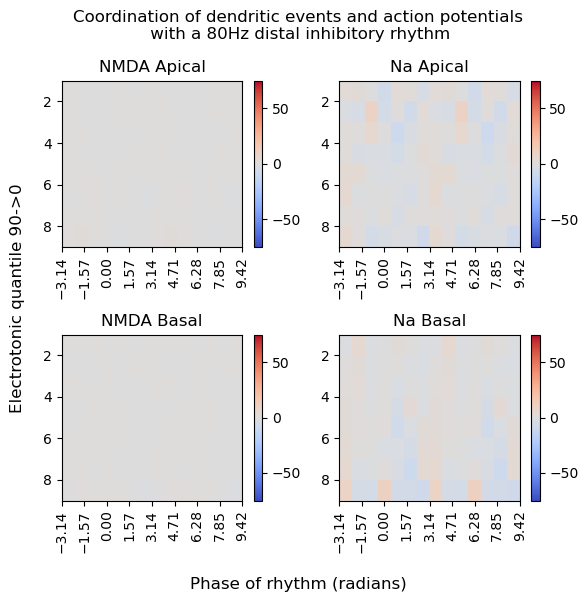

In [16]:
for i, (k,v) in enumerate(bin_data.items()):
    fig,ax = plt.subplots(2,2)
    plot_dend_set(v, [-75, 75], fig, ax)
    fig.suptitle('Coordination of dendritic events and action potentials\n'
             + ' with a {}Hz distal inhibitory rhythm'.format(k))
    fig.set_size_inches(6,6)
    fig.tight_layout()

## Entrainment to rhythm phase

In [50]:
ent_data_prox = {}
for k, v in sim_dicts.items():
    print('Processing ' + k)
    ent_data_prox[k] = ent_files_func(v)


Processing p5


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)


Processing 2


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)


Processing 5


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)


Processing 10


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)


Processing 16


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)


Processing 20


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)


Processing 30


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)


Processing 40


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)


Processing 50


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)


Processing 60


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)


Processing 80


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))


Text(0.5, 0, 'Frequency (Hz)')

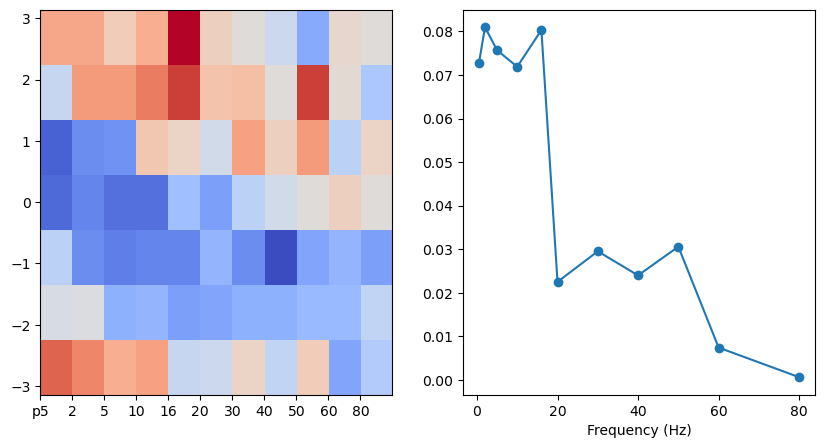

In [51]:
# AP entrainment
ap_ent = np.array([ent_data_prox[k]['ap_ppc'] for k in freq_list_str])
ap_hist = np.array([ent_data_prox[k]['ap_hist'] for k in freq_list_str]).T
fig, ax = plt.subplots(1,2, figsize=[10,5])
ax[0].imshow(ap_hist, aspect='auto', cmap='coolwarm', 
           extent=[0, len(freq_list_str), -np.pi, np.pi])
ax[0].set_xticks(np.arange(len(freq_list_str)))
ax[0].set_xticklabels(freq_list_str)
ax[1].plot(freq_list, ap_ent, marker='o')
ax[1].set_xlabel('Frequency (Hz)')

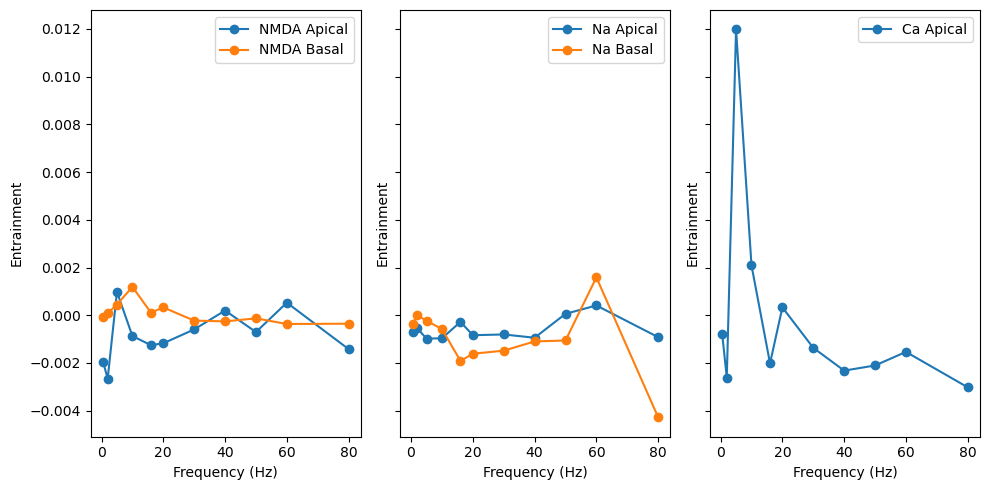

In [45]:
# entrainment for each type of dendritic event
nmda_a_ent = np.array([ent_data_prox[k]['nmda_a_ppc_on'][:-1] for k in freq_list_str]).mean(axis=1)
nmda_b_ent = np.array([ent_data_prox[k]['nmda_b_ppc_on'][:-1] for k in freq_list_str]).mean(axis=1)
na_a_ent = np.array([ent_data_prox[k]['na_a_ppc_on'][:-1] for k in freq_list_str]).mean(axis=1)
na_b_ent = np.array([ent_data_prox[k]['na_b_ppc_on'][:-1] for k in freq_list_str]).mean(axis=1)
ca_a_ent = np.array([ent_data_prox[k]['ca_a_ppc_on'][:-1] for k in freq_list_str]).mean(axis=1)

fig, ax = plt.subplots(1,3, figsize=[10,5], sharey=True)
ax[0].plot(freq_list, nmda_a_ent, marker='o', label='NMDA Apical')
ax[0].plot(freq_list, nmda_b_ent, marker='o', label='NMDA Basal')
ax[0].set_xlabel('Frequency (Hz)')
ax[0].set_ylabel('Entrainment')
ax[0].legend()
ax[1].plot(freq_list, na_a_ent, marker='o', label='Na Apical')
ax[1].plot(freq_list, na_b_ent, marker='o', label='Na Basal')
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Entrainment')
ax[1].legend()
ax[2].plot(freq_list, ca_a_ent, marker='o', label='Ca Apical')
ax[2].set_xlabel('Frequency (Hz)')
ax[2].set_ylabel('Entrainment')
ax[2].legend()
fig.tight_layout()

In [41]:
# parmameters for plotting inhibitory afferent phase time series
inh_window = np.array([0, 0.5]) # seconds
bin_len = 0.004 # seconds

inh_offset = 97.0 # seconds 9

# compartments to plot
soma_ind = 2
basal_ind = 760
apic_ind = 1683

def plot_rhythm_trace(sim_dict, window, freq, axs=None):
    if axs is None:
        fig, axs = plt.subplots(3,1, figsize=[10, 4])

    vm_f = h5py.File(sim_dict['VmFile'], 'r')
    vm_soma = vm_f['report']['biophysical']['data'][:, soma_ind]
    vm_basal = vm_f['report']['biophysical']['data'][:, basal_ind]
    vm_apic = vm_f['report']['biophysical']['data'][:, apic_ind]
    vm_t_params = vm_f['report']['biophysical']['mapping']['time']
    vm_t = np.arange(vm_t_params[0], vm_t_params[1], vm_t_params[2])/1000
    vm_inds = np.where((vm_t >= window[0]) & (vm_t <= window[1]))

    ca_spks = pd.read_csv(sim_dict['CaFile'])
    ca_spks = ca_spks[ca_spks['segmentID']==apic_ind][['ca_lower_bound', 'ca_upper_bound']].values
    ca_times = vm_t[ca_spks.astype(int)]
    ca_times = ca_times[(ca_times[:,0] >= window[0]) & (ca_times[:,1] <= window[1])]
    

    nmda_spks = pd.read_csv(sim_dict['NMDAFile'])
    nmda_spks = nmda_spks[nmda_spks['segmentID']==basal_ind][['nmda_lower_bound', 'nmda_upper_bound']].values
    nmda_times = vm_t[nmda_spks.astype(int)]
    nmda_times = nmda_times[(nmda_times[:,0] >= window[0]) & (nmda_times[:,1] <= window[1])]

    
    axs[0].plot(vm_t[vm_inds], vm_soma[vm_inds])
    axs[0].plot(vm_t[vm_inds], (np.sin(vm_t[vm_inds]*2*np.pi*freq)*10)-65, color='r')
    axs[0].set_ylim([-80, -40])
    axs[0].title.set_text('Soma Vm ' + str(round(vm_soma[vm_inds][0])))
    axs[1].plot(vm_t[vm_inds], vm_basal[vm_inds])
    axs[1].plot(vm_t[vm_inds], (np.sin(vm_t[vm_inds]*2*np.pi*freq)*10)-65, color='r')
    for i in range(len(nmda_times)):
        axs[1].axvspan(nmda_times[i, 0], nmda_times[i, 1], color='m', alpha=0.2)
    axs[1].set_ylim([-76, 0])
    axs[1].title.set_text('Basal Vm ' + str(round(vm_basal[vm_inds][0])))
    axs[2].plot(vm_t[vm_inds], vm_apic[vm_inds])
    axs[2].plot(vm_t[vm_inds], (np.sin(vm_t[vm_inds]*2*np.pi*freq)*10)-65, color='r')
    for i in range(len(ca_times)):
        axs[2].axvspan(ca_times[i, 0], ca_times[i, 1], color='g', alpha=0.2)
    axs[2].set_ylim([-76, 20])
    axs[2].title.set_text('Apical Vm ' + str(round(vm_apic[vm_inds][0])))
    return axs

C:\Users\dbh60\AppData\Local\Temp\ipykernel_17404\2592688929.py:24: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  ca_spks = pd.read_csv(sim_dict['CaFile'])
C:\Users\dbh60\AppData\Local\Temp\ipykernel_17404\2592688929.py:30: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  nmda_spks = pd.read_csv(sim_dict['NMDAFile'])


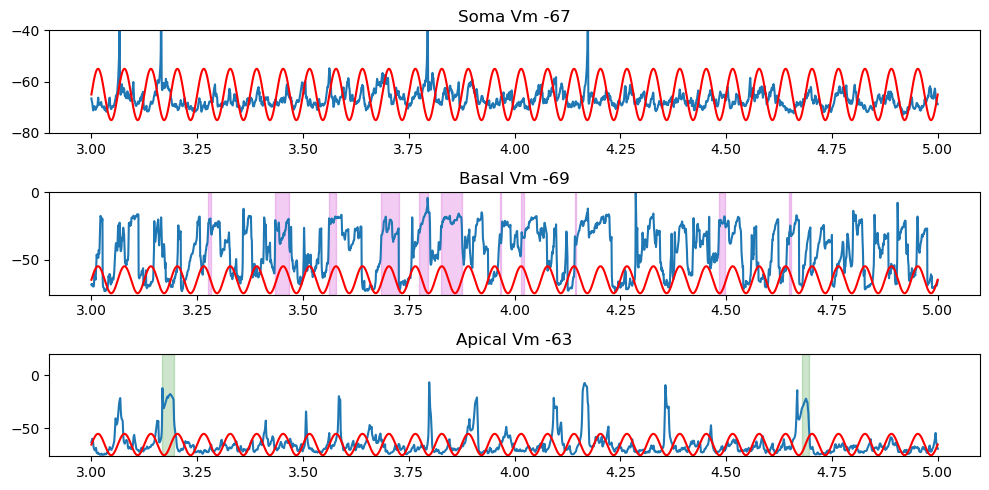

In [42]:
fig, axs = plt.subplots(3,1, figsize=(10, 5)) #152 153, 217 218
plot_rhythm_trace(sim_dicts['10'], [3, 5], 16, axs=axs)
fig.tight_layout()
fig.savefig('C:\\Users\\dbh60\\Documents\\Analysis\\InhibOnDendComp\\figures\\VmTraces_10HzDistal.pdf')